In [1]:
from protopnet.datasets.torch_extensions import CachedPartLabels, LoaderBundle, TensorToDictDatasetAdapter
import scanpy as sc
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from protopnet.visualization import KeyReturningDict

/home/users/jcd97/code/ubc_bootcamp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from protopnet.datasets.ubc_cells import train_dataloaders

In [3]:
loader_bundle_w_exclusions = train_dataloaders(
    excluded_classes=[
        "Miscellaneuous",
        "unannoted", 
        "Splatter", 
        "Deep-layer intratelencephalic", 
        "MGE interneuron", 
        "Astrocyte", 
        "Amygdala excitatory"
    ]
)
classnames_w_exclusions = loader_bundle_w_exclusions.class_name_ref_dict
del loader_bundle_w_exclusions

loader_bundle = train_dataloaders(
    excluded_classes=[
        # "Miscellaneuous",
        # "unannoted", 
        # "Splatter", 
        # "Deep-layer intratelencephalic", 
        # "MGE interneuron", 
        # "Astrocyte", 
        # "Amygdala excitatory"
    ]
)

About to run load
Data loaded successfully from /usr/xtmp/jcd97/datasets/mini_data.h5ad
About to run preprocess
Grabbing highly variable


/home/users/jcd97/code/ubc_bootcamp/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Normalizing
Log
Scale


/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Returning
Finished Pre-processing
Before exclusion: (48919,), ['Amygdala excitatory' 'Astrocyte' 'CGE interneuron'
 'Cerebellar inhibitory' 'Committed oligodendrocyte precursor'
 'Deep-layer corticothalamic and 6b' 'Deep-layer intratelencephalic'
 'Deep-layer near-projecting' 'Eccentric medium spiny neuron' 'Fibroblast'
 'Hippocampal CA1-3' 'Hippocampal CA4' 'LAMP5-LHX6 and Chandelier'
 'Lower rhombic lip' 'MGE interneuron' 'Mammillary body'
 'Medium spiny neuron' 'Microglia' 'Miscellaneous' 'Oligodendrocyte'
 'Oligodendrocyte precursor' 'Splatter' 'Thalamic excitatory'
 'Upper-layer intratelencephalic' 'Vascular' 'unannoted']
After exclusion: (34798,), ['CGE interneuron' 'Cerebellar inhibitory'
 'Committed oligodendrocyte precursor' 'Deep-layer corticothalamic and 6b'
 'Deep-layer near-projecting' 'Eccentric medium spiny neuron' 'Fibroblast'
 'Hippocampal CA1-3' 'Hippocampal CA4' 'LAMP5-LHX6 and Chandelier'
 'Lower rhombic lip' 'Mammillary body' 'Medium spiny neuron' 'Microglia'
 'Mis

/home/users/jcd97/code/ubc_bootcamp/UBC-cell/proto-rset/protopnet/datasets/ubc_cells.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_kept = all_data_X[kept_samples]


21 Classes
About to run load
Data loaded successfully from /usr/xtmp/jcd97/datasets/mini_data.h5ad
About to run preprocess
Grabbing highly variable
Normalizing
Log
Scale


/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Returning
Finished Pre-processing
Before exclusion: (48919,), ['Amygdala excitatory' 'Astrocyte' 'CGE interneuron'
 'Cerebellar inhibitory' 'Committed oligodendrocyte precursor'
 'Deep-layer corticothalamic and 6b' 'Deep-layer intratelencephalic'
 'Deep-layer near-projecting' 'Eccentric medium spiny neuron' 'Fibroblast'
 'Hippocampal CA1-3' 'Hippocampal CA4' 'LAMP5-LHX6 and Chandelier'
 'Lower rhombic lip' 'MGE interneuron' 'Mammillary body'
 'Medium spiny neuron' 'Microglia' 'Miscellaneous' 'Oligodendrocyte'
 'Oligodendrocyte precursor' 'Splatter' 'Thalamic excitatory'
 'Upper-layer intratelencephalic' 'Vascular' 'unannoted']
After exclusion: (48919,), ['Amygdala excitatory' 'Astrocyte' 'CGE interneuron'
 'Cerebellar inhibitory' 'Committed oligodendrocyte precursor'
 'Deep-layer corticothalamic and 6b' 'Deep-layer intratelencephalic'
 'Deep-layer near-projecting' 'Eccentric medium spiny neuron' 'Fibroblast'
 'Hippocampal CA1-3' 'Hippocampal CA4' 'LAMP5-LHX6 and Chandelier'
 'Lower rho

/home/users/jcd97/code/ubc_bootcamp/UBC-cell/proto-rset/protopnet/datasets/ubc_cells.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_kept = all_data_X[kept_samples]


27 Classes


In [4]:
X = loader_bundle.val_loader.dataset.tensor_dataset.tensors[0]
Y = loader_bundle.val_loader.dataset.tensor_dataset.tensors[1]

In [5]:
def get_ood_preds_labels(model, X, Y, extra_classes_to_skip=[]):
    preds_dict = model(X.cuda().unsqueeze(-1).unsqueeze(-1), True)

    preds = preds_dict['logits']
    proto_acts = preds_dict['prototype_activations']
    vals, predicted_classes = torch.max(preds, dim=1)

    probs = torch.softmax(preds, dim=-1)
    entropies = Categorical(probs).entropy()

    label_names = np.array([loader_bundle.class_name_ref_dict[val.item()] for val in Y])

    in_distr_samples = np.isin(
        label_names, 
        np.array(list(classnames_w_exclusions.values()))
    )
    ood_samples = ~in_distr_samples

    skipped_class_mask = np.isin(
        label_names, 
        extra_classes_to_skip
    )

    max_proto_act_by_sample, proto = torch.topk(proto_acts.squeeze(-1).squeeze(-1), dim=-1, k=1)
    max_proto_act_by_sample = max_proto_act_by_sample.mean(axis=1)

    return in_distr_samples[~skipped_class_mask], max_proto_act_by_sample[~skipped_class_mask].cpu().detach().numpy(), entropies[~skipped_class_mask].cpu().detach().numpy()

AttributeError: 'Delete' object has no attribute 'value'

In [ ]:
preds_dict = model(X.cuda().unsqueeze(-1).unsqueeze(-1), True)

preds = preds_dict['logits']

probs = torch.softmax(preds, dim=-1)
entropies = Categorical(probs).entropy()

In [ ]:
import torch
# Model that only looks at input space, few prototypes, all classes (no OOD)
model = torch.load(
    "/usr/xtmp/jcd97/proto-rset/wandb/live/artifacts/z5zrqhrl/650_last_only_0.8454.pth", weights_only=False
)

# Model that looks at only input space, with the default classes held out for OOD
model_input_space = torch.load(
    "/usr/xtmp/jcd97/proto-rset/wandb/live/artifacts/wu973a12/651_last_only_0.8798.pth", weights_only=False
)

# Model that looks at latent space, with the default classes held out for OOD
model_latent_space = torch.load(
    "/usr/xtmp/jcd97/proto-rset/wandb/live/artifacts/wu973a12/501_last_only_0.9280.pth", weights_only=False
)

### Compare max prototype similarity for in sample vs out of sample

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0, 0.5, 'TPR')

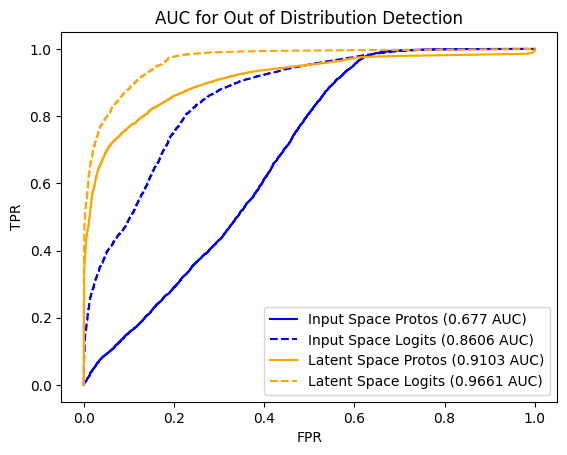

In [112]:
in_distr_samples, max_proto_act_by_sample, entropies_input_space = get_ood_preds_labels(
    model_input_space, 
    X, 
    Y,
    extra_classes_to_skip=[
        "Miscellaneuous",
        "unannoted", 
        "Splatter",
    ]
)
fpr, tpr, cuts = roc_curve(in_distr_samples, max_proto_act_by_sample)
plt.plot(fpr, tpr, color="blue", linestyle='solid')
auc_input_space_proto = roc_auc_score(in_distr_samples, max_proto_act_by_sample)

fpr, tpr, cuts = roc_curve(in_distr_samples, 1 - entropies_input_space)
plt.plot(fpr, tpr, color="blue", linestyle='dashed')
auc_input_space_entropy = roc_auc_score(in_distr_samples, 1 - entropies_input_space)


in_distr_samples, max_proto_act_by_sample, entropies_latent_space = get_ood_preds_labels(
    model_latent_space,
    X, 
    Y,
    extra_classes_to_skip=[
        "Miscellaneuous",
        "unannoted",
        "Splatter"
    ]
)
fpr, tpr, cuts = roc_curve(in_distr_samples, max_proto_act_by_sample)
plt.plot(fpr, tpr, color="orange", linestyle="solid")
auc_latent_space_proto = roc_auc_score(in_distr_samples, max_proto_act_by_sample)

fpr, tpr, cuts = roc_curve(in_distr_samples, 1 - entropies_latent_space)
plt.plot(fpr, tpr, color="orange", linestyle="dashed")
auc_latent_space_entropy = roc_auc_score(in_distr_samples, 1 - entropies_latent_space)


plt.legend([
    f"Input Space Protos ({round(auc_input_space, 4)} AUC)",
    f"Input Space Logits ({round(auc_input_space_entropy, 4)} AUC)",
    f"Latent Space Protos ({round(auc_latent_space, 4)} AUC)",
    f"Latent Space Logits ({round(auc_latent_space_entropy, 4)} AUC)"
])
plt.title(f"AUC for Out of Distribution Detection")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [104]:
in_distr_samples.shape

(24250,)

### Compare entropy in logits for in sample vs out of sample

In [76]:
from torch.distributions import Categorical
in_distr_probs = torch.softmax(preds[in_distr_samples], dim=-1)
print(f"Mean in distribution entropy: {Categorical(in_distr_probs).entropy().mean()}")

ood_probs = torch.softmax(preds[ood_samples], dim=-1)
print(f"Mean OOD entropy: {Categorical(ood_probs).entropy().mean()}")

Mean in distribution entropy: 0.1268712282180786
Mean OOD entropy: 1.1003172397613525


(array([ 692.,  618., 1209.,  881.,  576.,  383.,  347.,  351.,  510.,
        1432.]),
 array([1.52290112e-03, 3.05523902e-01, 6.09524906e-01, 9.13525939e-01,
        1.21752691e+00, 1.52152789e+00, 1.82552898e+00, 2.12952995e+00,
        2.43353105e+00, 2.73753214e+00, 3.04153299e+00]),
 <BarContainer object of 10 artists>)

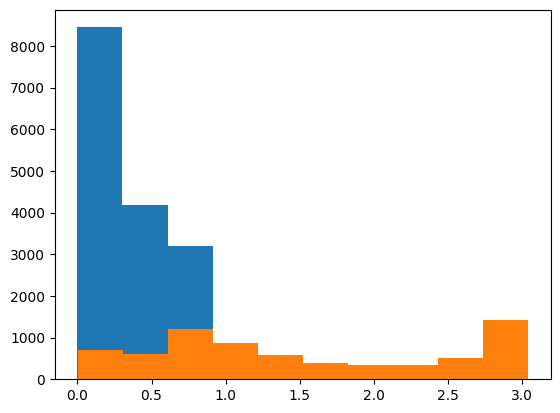

In [45]:
from matplotlib import pyplot as plt
plt.hist(Categorical(in_distr_probs).entropy().cpu().detach().numpy())
plt.hist(Categorical(ood_probs).entropy().cpu().detach().numpy())

In [40]:
preds[in_distr_samples].shape

torch.Size([17460, 21])

In [ ]:
classname_to_ind = {v: k for k, v in classnames_w_exclusions.items()}

In [20]:
predicted_class_names = [classnames_w_exclusions[p.item()] for p in predicted_classes]

In [31]:
proto_acts = proto_acts.view(proto_acts.shape[0], proto_acts.shape[1])
proto_acts.max(dim=-1)[0].min()

tensor(0.0156, device='cuda:0')

In [54]:
proto_acts.max(dim=-1)[0].mean()

tensor(0.0238, device='cuda:0', grad_fn=<MeanBackward0>)

In [9]:
torch.unique(inds, return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 21, 23],
        device='cuda:0'),
 tensor([2458, 4442, 1589,  627,  197, 1681,  162,  234, 1846,  642,    3, 5252,
         2941, 1430,   33,   11,  856,   55], device='cuda:0'))

In [10]:
torch.unique(Y, return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 20, 21, 22, 23]),
 tensor([2379, 4163, 1448,  738,  355, 1640,  174,  223, 1828,  598,  183, 4154,
         2905, 2571,   50,   28,    5,  163,    4,    2,  788,    3,   57]))

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(Y.cpu().numpy(), inds.cpu().numpy(), normalize="true")

### First, let's confirm we're not just predicting the majority class

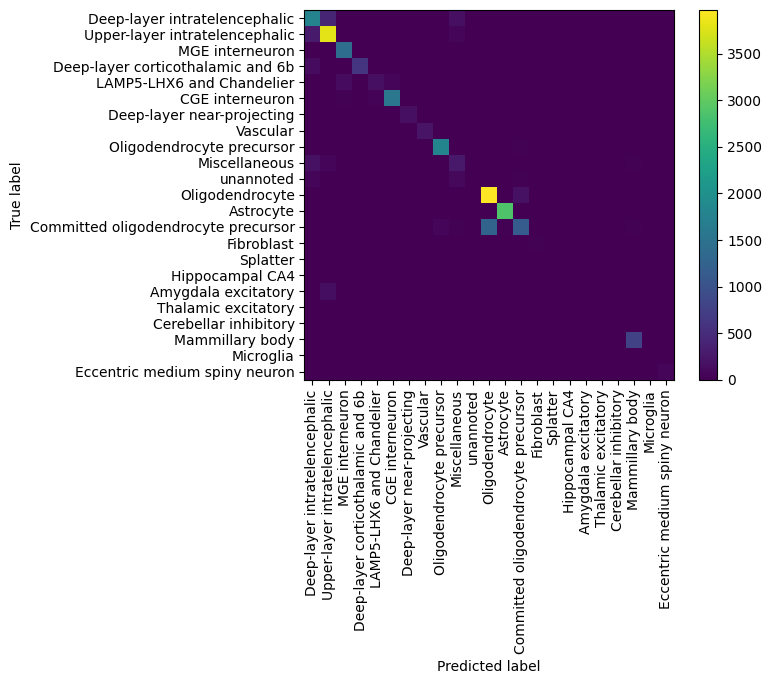

In [14]:
ConfusionMatrixDisplay.from_predictions(
    Y.cpu().numpy(), 
    inds.cpu().numpy(),
    xticks_rotation="vertical",
    values_format='.1g',
    normalize=None,
    include_values=False,
    display_labels=list(names.values())[:-3]
)
# Miscellaneuous, unannoted, Splatter, Deep-layer intratelencephalic, MGE interneuron, Astrocyte, Amygdala excitatory

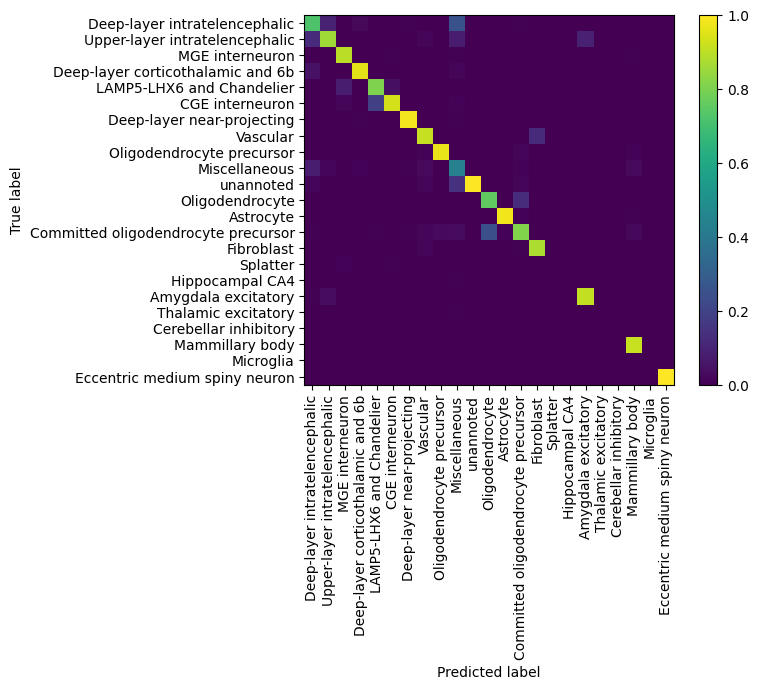

In [17]:
ConfusionMatrixDisplay.from_predictions(
    Y.cpu().numpy(), 
    inds.cpu().numpy(),
    xticks_rotation="vertical",
    values_format='.1g',
    normalize="pred",
    include_values=False,
    display_labels=list(names.values())[:-3],
)

### Next, let's see how "few hot" our prototypes are

In [118]:
model.prune_duplicate_prototypes()

In [114]:
torch.sum(model.prototype_layer.prototype_class_identity, dim=0)

tensor([2., 4., 2., 1., 4., 2., 5., 4., 3., 3., 4., 1., 2., 1., 2., 4., 2., 4.,
        1., 1., 0.], device='cuda:0')

In [115]:
model.prototype_layer.prototype_class_identity[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')

In [27]:
vals, inds = torch.topk(model.prototype_layer.prototype_tensors.view(-1, 1000), k=1, dim=-1)

In [29]:
inds.flatten().unique()

torch.Size([530])

In [119]:
proto_tensors = model.prototype_layer.prototype_tensors[:5].squeeze(-1).squeeze(-1)

<Axes: >

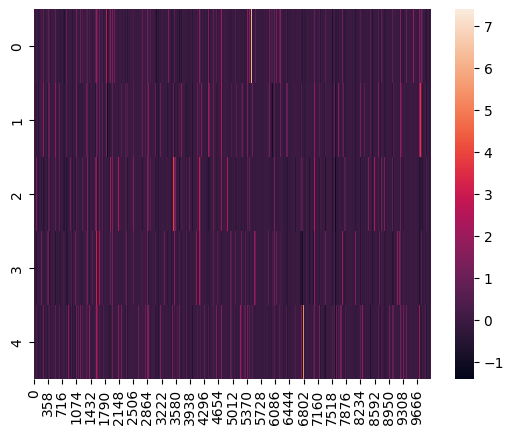

In [120]:
import seaborn as sns
sns.heatmap(
    proto_tensors.detach().cpu().numpy()
)

<Axes: >

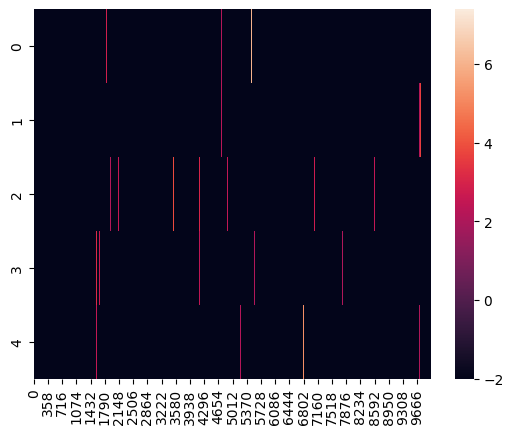

In [122]:
proto_tensors = proto_tensors.detach().cpu()
proto_tensors[proto_tensors <= 2] =  -2
sns.heatmap(
    proto_tensors.numpy()
)
plt.xlabel("Prototype index")
plt.ylabel("Gene index")